In [1]:
# Import necessary libraries
import os
import random
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# Extract data from the zip file
shutil.unpack_archive('RiceLeafDiseaseImages.zip', 'RiceLeafDiseaseImages')

# Load images and split them in train, validation and test folders

In [3]:
# Define a function to load and resize images
def load_and_resize_image(file_path, target_shape=(128, 128)):
    image = cv2.imread(file_path)
    resized_image = cv2.resize(image, target_shape)
    return resized_image

In [4]:
# Define a function to load each image class (target) stored by individual directory. 
# Each class directory contains its respective images
def load_image_class_by_directory(image_dir):
    # Load and resize images
    image_files = os.listdir(image_dir)
    images = []
    for file in image_files:
        if file.endswith('.jpg') or file.endswith('.JPG'):
            image_path = os.path.join(image_dir, file)
            resized_image = load_and_resize_image(image_path)
            images.append(resized_image)

    print(f"Num of images: {len(images)}")        
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [5]:
# Define a function to display some images
def display_images(images, num_images_to_display = 6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        # Convert the image to a supported depth (e.g., CV_8U) before color conversion
        image = images[i].astype(np.uint8)
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying with matplotlib
        axes[i].axis('off')
    plt.show()

Num of images: 1584
Single image shape before flattening: (128, 128, 3)


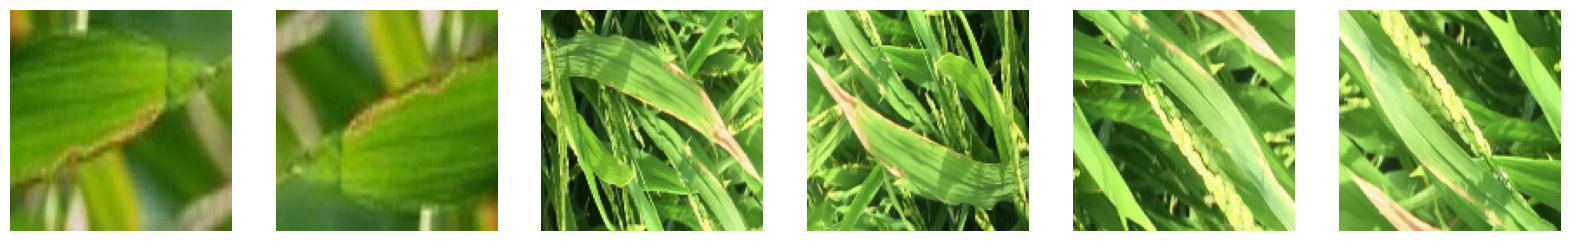

In [6]:
# Display some images in the target class 'Bacterialblight'
image_dir = "RiceLeafDiseaseImages/Bacterialblight"
images_Bacterialblight = load_image_class_by_directory(image_dir)
display_images(images_Bacterialblight)

Num of images: 1440
Single image shape before flattening: (128, 128, 3)


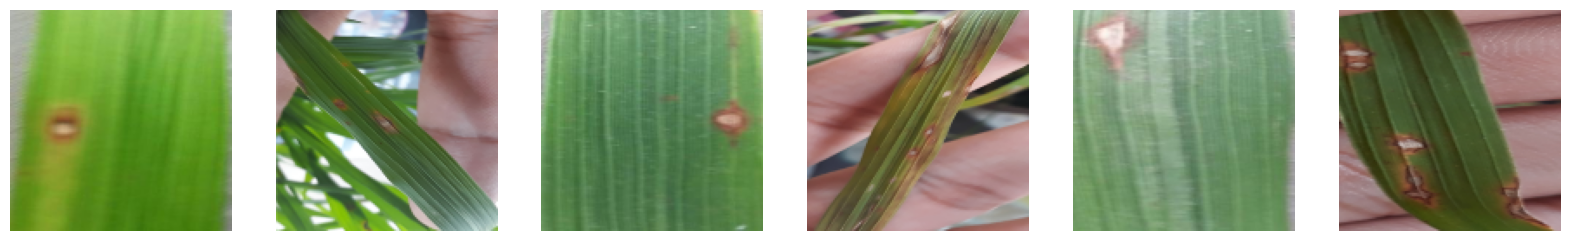

In [7]:
# Display some images in the target class 'Blast'
image_dir = "RiceLeafDiseaseImages/Blast"
images_Blast = load_image_class_by_directory(image_dir)
display_images(images_Blast)

Num of images: 1600
Single image shape before flattening: (128, 128, 3)


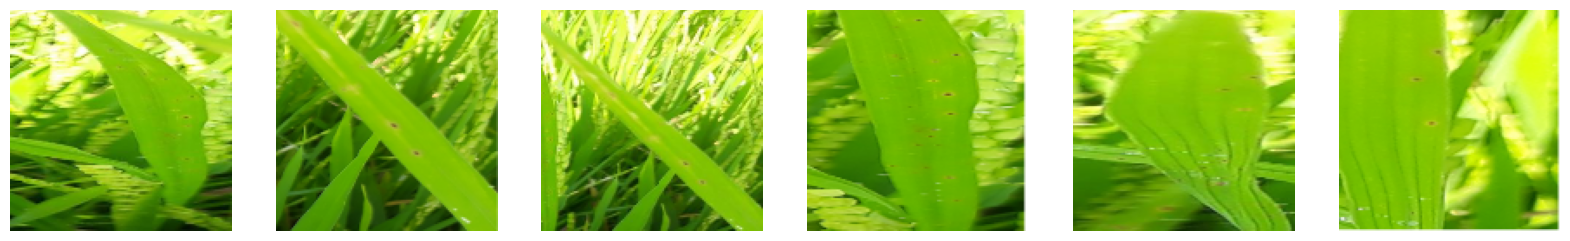

In [8]:
# Display some images in the target class 'Brownspot'
image_dir = "RiceLeafDiseaseImages/Brownspot"
images_Brownspot = load_image_class_by_directory(image_dir)
display_images(images_Brownspot)

Num of images: 1308
Single image shape before flattening: (128, 128, 3)


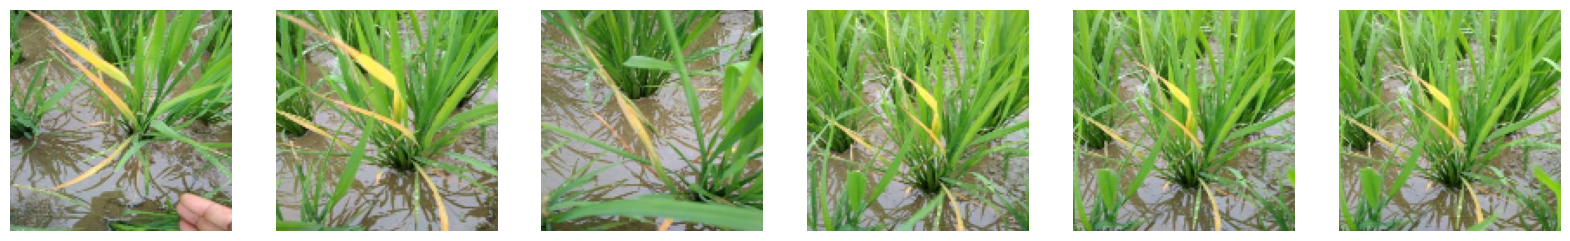

In [9]:
# Display some images in the target class 'Tungro'
image_dir = "RiceLeafDiseaseImages/Tungro"
images_Tungro = load_image_class_by_directory(image_dir)
display_images(images_Tungro)

In [10]:
# Define the base directory where to create the train, validation and test folders
source_dir = "RiceLeafDiseaseImages"

# Define the train, validation and test folders
train_dir = os.path.join(source_dir, "train")
val_dir = os.path.join(source_dir, "validation")
test_dir = os.path.join(source_dir, "test")


In [11]:
# Define the percentage of images for each split
train_percentage = 0.7
val_percentage = 0.2
test_percentage = 0.1

In [12]:
# Function to create directories for a single class in train, validation, and test folders
def create_class_directories(class_name, train_dir, val_dir, test_dir):
    dest_class_train_path = os.path.join(train_dir, class_name)
    dest_class_val_path = os.path.join(val_dir, class_name)
    dest_class_test_path = os.path.join(test_dir, class_name)
    os.makedirs(dest_class_train_path, exist_ok=True)
    os.makedirs(dest_class_val_path, exist_ok=True)
    os.makedirs(dest_class_test_path, exist_ok=True)

In [13]:
# Create directories for each class in train, validation, and test folders
def create_class_directories_for_all_classes(classes, train_dir, val_dir, test_dir):
    for class_name in classes:
        create_class_directories(class_name, train_dir, val_dir, test_dir)

In [14]:
# Function to move images for a single class
def move_images_for_class(class_name, source_dir, train_dir, val_dir, test_dir):
    class_path = os.path.join(source_dir, class_name)
    dest_class_train_path = os.path.join(train_dir, class_name)
    dest_class_val_path = os.path.join(val_dir, class_name)
    dest_class_test_path = os.path.join(test_dir, class_name)
    
    # List all images in the class folder
    images = os.listdir(class_path)
    total_images = len(images)
    num_train = int(total_images * train_percentage)
    num_val = int(total_images * val_percentage)
    num_test = total_images - num_train - num_val
    
    # Randomly shuffle images
    random.shuffle(images)
    
    # Move images to destination class folders
    for i, file_name in enumerate(images):
        if i < num_train:
            shutil.move(os.path.join(class_path, file_name), dest_class_train_path)
        elif i < num_train + num_val:
            shutil.move(os.path.join(class_path, file_name), dest_class_val_path)
        else:
            shutil.move(os.path.join(class_path, file_name), dest_class_test_path)

# Move images for each class
def move_images_for_all_classes(classes, source_dir, train_dir, val_dir, test_dir):
    for class_name in classes:
        move_images_for_class(class_name, source_dir, train_dir, val_dir, test_dir)

# List the names of the classes
classes = os.listdir(source_dir)

# Create directories for each class in train, validation, and test folders
create_class_directories_for_all_classes(classes, train_dir, val_dir, test_dir)

# Move images for each class
move_images_for_all_classes(classes, source_dir, train_dir, val_dir, test_dir)

In [15]:
# Define image dimensions and batch size
img_width, img_height = 128, 128
batch_size = 32

In [16]:
# Create ImageDataGenerator instances for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# Create generators for training, validation, and testing datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4150 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Found 597 images belonging to 4 classes.


# Build a deep learning model

In [19]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [20]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model

In [21]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/15
129/129 [==============================] - 145s 1s/step - loss: 1.1960 - accuracy: 0.4483 - val_loss: 0.8767 - val_accuracy: 0.6495
Epoch 2/15
129/129 [==============================] - 144s 1s/step - loss: 0.7849 - accuracy: 0.6848 - val_loss: 0.5459 - val_accuracy: 0.7686
Epoch 3/15
129/129 [==============================] - 156s 1s/step - loss: 0.5729 - accuracy: 0.7759 - val_loss: 0.5337 - val_accuracy: 0.7855
Epoch 4/15
129/129 [==============================] - 241s 2s/step - loss: 0.4713 - accuracy: 0.8116 - val_loss: 0.4993 - val_accuracy: 0.8057
Epoch 5/15
129/129 [==============================] - 372s 3s/step - loss: 0.3756 - accuracy: 0.8475 - val_loss: 0.2523 - val_accuracy: 0.8885
Epoch 6/15
129/129 [==============================] - 291s 2s/step - loss: 0.3024 - accuracy: 0.8754 - val_loss: 0.4790 - val_accuracy: 0.8311
Epoch 7/15
129/129 [==============================] - 216s 2s/step - loss: 0.2599 - accuracy: 0.9053 - val_loss: 0.4116 - val_accuracy: 0.8429

In [22]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

19/19 - 9s - loss: 0.0761 - accuracy: 0.9749 - 9s/epoch - 458ms/step

Test accuracy: 0.9748743772506714


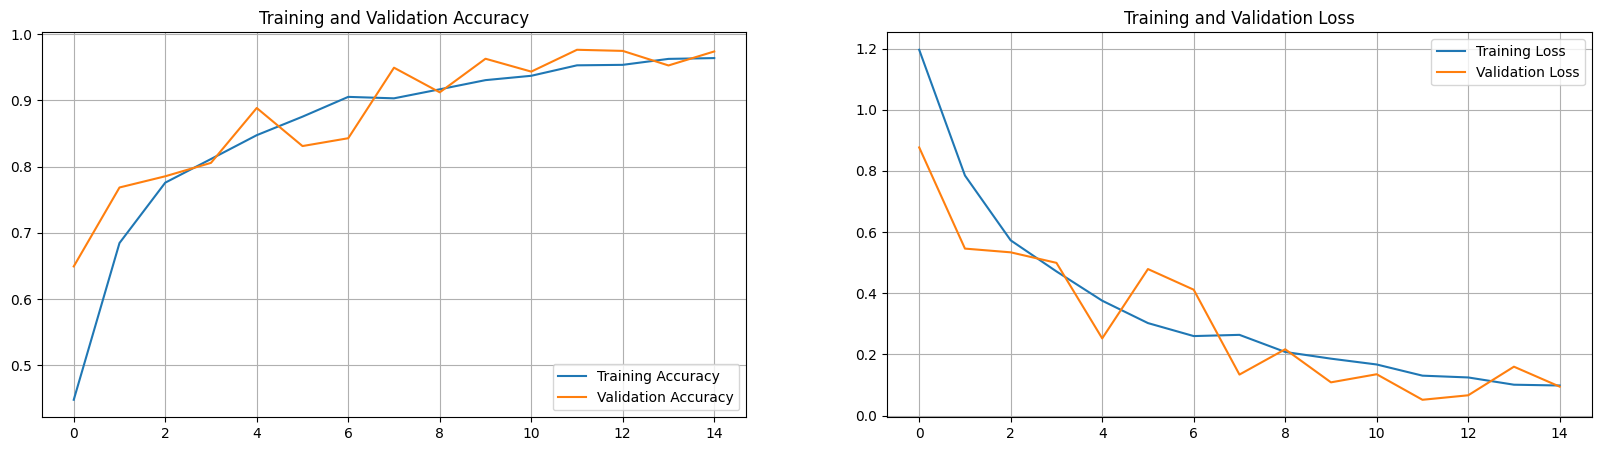

In [23]:
# Plot evaluation
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(15)
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.show()

1/1 [==============================] - 0s 139ms/step


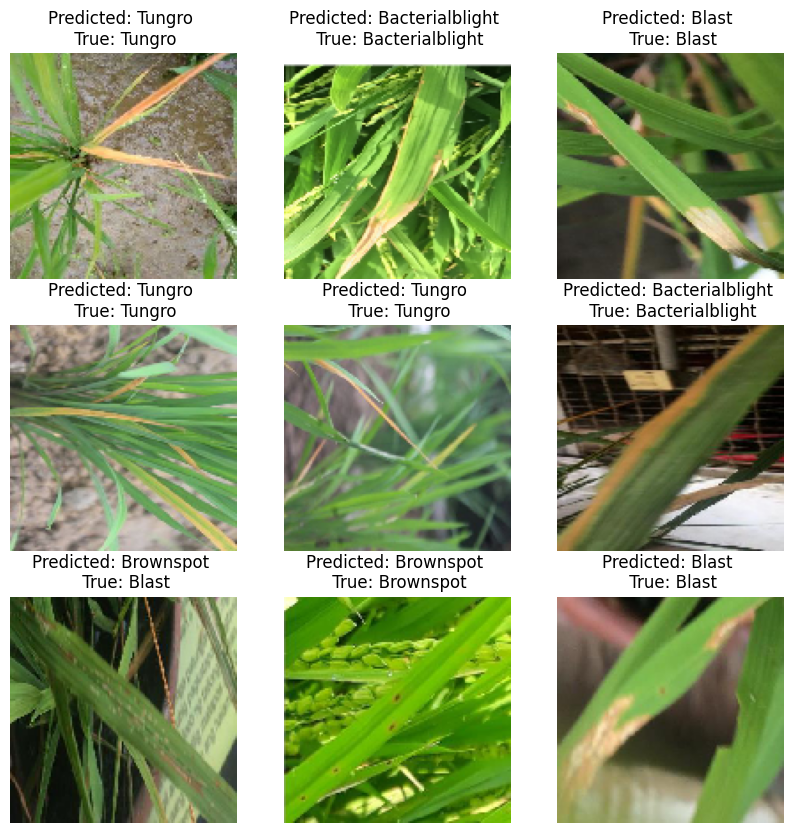

In [47]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Predict classes for some sample images from the testing dataset
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)

# Display some sample images along with their predicted classes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    predicted_class = class_labels[np.argmax(predictions[i])]
    true_class = class_labels[np.argmax(sample_labels[i])]
    plt.title(f'Predicted: {predicted_class} \n True: {true_class}')
    plt.axis('off')
plt.show()